In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sklearn
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-rc1
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
matplotlib 2.1.0
numpy 1.18.0
pandas 0.20.3
sklearn 0.21.3
tensorflow 2.0.0-rc1
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [17]:
# 函数式API 功能API
inputs = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation="relu")(inputs)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
#复合函数：f(x)=h(g(x))
concat = keras.layers.concatenate([inputs,hidden2])
outputs = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [inputs],
                          outputs = [outputs])

sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = "mean_squared_error",optimizer = sgd)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 30)           270         input_9[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 30)           930         dense_25[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 38)           0           input_9[0][0]                    
                                                                 dense_26[0][0]             

In [18]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]

history = model.fit(x_train_scaled,y_train,
                     validation_data=(x_valid_scaled,y_valid),
                   epochs = 100,
                   callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 62us/sample - loss: 2.1412 - val_loss: 0.7999
Epoch 2/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6850 - val_loss: 0.6810
Epoch 3/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6224 - val_loss: 0.6401
Epoch 4/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5942 - val_loss: 0.6150
Epoch 5/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5752 - val_loss: 0.5951
Epoch 6/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5594 - val_loss: 0.5822
Epoch 7/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5470 - val_loss: 0.5671
Epoch 8/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.5363 - val_loss: 0.5550
Epoch 9/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.527

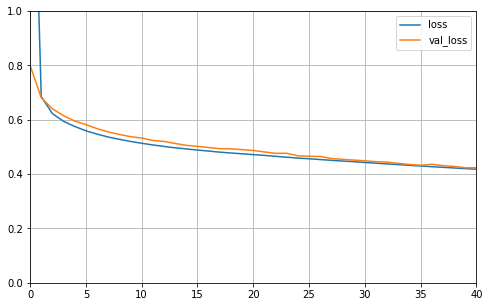

In [19]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.4670157215391943

In [12]:
# 子类API

class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30,activation="relu")
        self.hidden2_layer = keras.layers.Dense(30,activation="relu")
        self.output_layer = keras.layers.Dense(1)
        
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input,hidden2])
        output = self.output_layer(concat)
        return output

#model = WideDeepModel()
model = keras.models.Sequential([
    WideDeepModel(),
])

model.build(input_shape=(None, 8)) #(样本的数目，输入的fetch的数目)
sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = "mean_squared_error",optimizer = sgd)
model.summary()
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_deep_model (WideDeepMod multiple                  1239      
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 多输出
input_wide = keras.layers.Input(shape = [5])
input_deep = keras.layers.Input(shape = [6])
hidden1 = keras.layers.Dense(30,activation="relu")(input_deep)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs = [input_wide, input_deep],
                         outputs = [output,output2])

model.summary()
model.compile(loss = "mean_squared_error",optimizer = "sgd")
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 30)           210         input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 30)           930         dense_15[0][0]                   
____________________________________________________________________________________________